In [33]:
import os
import re
import ast

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
from neurovlm.data import get_data_dir
from neurovlm.models import Specter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [5]:
# # Load specter
# specter_neuro = Specter("allenai/specter2", adapter="Jerjes/neuro-specter2-multi-pool")
# specter_adhoc = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")

In [6]:
# # Read data
# neuro_structured = pd.read_csv('../../neuro_structured.csv')
# neuro_judge = pd.read_csv('../../neuro_judge.csv')

In [7]:
# def extract_markdown_sections(
#     df: pd.DataFrame,
#     text_col: str,
#     sections=(
#         "Networks",
#         "Key Regions",
#         "Cognitive Functions",
#         "Clinical Relevance",
#     ),
# ) -> pd.DataFrame:
#     """
#     Extracts Markdown sections (### Section Name) from a text column
#     and returns a new DataFrame with additional columns per section.
#     """

#     def parse_text(text):
#         if not isinstance(text, str):
#             return {s: "" for s in sections}

#         # Regex to capture ### Header followed by text until next ### or end
#         pattern = r"###\s+(.*?)\n(.*?)(?=\n###|\Z)"
#         matches = re.findall(pattern, text, flags=re.DOTALL)

#         parsed = {s: "" for s in sections}
#         for header, content in matches:
#             header = header.strip()
#             if header in parsed:
#                 parsed[header] = content.strip()

#         return parsed

#     extracted = df[text_col].apply(parse_text)
#     extracted_df = pd.DataFrame(extracted.tolist(), index=df.index)

#     return pd.concat([df.copy(), extracted_df], axis=1)


# structured_summaries_df = extract_markdown_sections(neuro_structured, text_col="structured_summary")
# braintotext_summaries_df = extract_markdown_sections(neuro_structured, text_col="brain_to_text_summary")

In [8]:
# # --- helper ---
# def embed_cell(x):
#     if pd.isna(x) or x == "":
#         return None

#     emb = specter_neuro(str(x))

#     # Handle torch / numpy / list outputs safely
#     if hasattr(emb, "detach"):        # torch.Tensor
#         emb = emb.detach().cpu().numpy()

#     emb = np.asarray(emb).squeeze()   # remove (1, D) → (D,)
#     return emb.tolist()


# # summaries
# structured_summaries_latents_df = pd.DataFrame(
#     index=structured_summaries_df.index
# )

# structured_summaries_latents_df["doi"] = structured_summaries_df["doi"]

# for col in [
#     "Networks",
#     "Key Regions",
#     "Cognitive Functions",
#     "Clinical Relevance",
# ]:
#     structured_summaries_latents_df[f"{col} latent"] = (
#         structured_summaries_df[col].apply(embed_cell)
#     )


In [9]:
# # brain to text summaries
# braintotext_summaries_latents_df = pd.DataFrame(
#     index=braintotext_summaries_df.index
# )   

# braintotext_summaries_latents_df["doi"] = braintotext_summaries_df["doi"]

# for col in [
#     "Networks",
#     "Key Regions",
#     "Cognitive Functions",
#     "Clinical Relevance",
# ]:
#     braintotext_summaries_latents_df[f"{col} latent"] = (
#         braintotext_summaries_df[col].apply(embed_cell)
#     )


In [10]:
# # Abstract and brain to text summary embeddings
# abstract_btt_df = pd.DataFrame(
#     index=braintotext_summaries_df.index
# )   

# abstract_btt_df["doi"] = braintotext_summaries_df["doi"]
# for col in [
#     "abstract",
#     "brain_to_text_summary"
# ]:
#     abstract_btt_df[f"{col} latent"] = (
#         braintotext_summaries_df[col].apply(embed_cell)
#     )

In [11]:
# structured_summaries_latents_df.to_csv("structured_summaries_latents.csv", index=False)
# braintotext_summaries_latents_df.to_csv("braintotext_summaries_latents.csv", index=False) 
# abstract_btt_df.to_csv("abstract_btt_latents.csv", index=False)

In [12]:
structured_summaries_latents_df = pd.read_csv("structured_summaries_latents.csv")
braintotext_summaries_latents_df = pd.read_csv("braintotext_summaries_latents.csv")
abstract_btt_df = pd.read_csv("abstract_btt_latents.csv")

In [18]:
def recall_at_k_random(
    col_a,
    col_b,
    ks=(10, 20, 50, 100, 150, 200),
    expected_dim=768,
):
    def parse_embedding(x):
        if x is None:
            return None
        if isinstance(x, str):
            x = ast.literal_eval(x)
        arr = np.asarray(x, dtype=np.float32)

        # reject scalars or wrong shapes
        if arr.ndim != 1 or arr.shape[0] != expected_dim:
            return None

        return arr

    # --- parse + filter jointly ---
    A_list = []
    B_list = []

    for a, b in zip(col_a, col_b):
        a_emb = parse_embedding(a)
        b_emb = parse_embedding(b)

        if a_emb is None or b_emb is None:
            continue

        A_list.append(a_emb)
        B_list.append(b_emb)

    if len(A_list) == 0:
        raise ValueError("No valid embedding pairs found.")

    A = np.vstack(A_list)
    B = np.vstack(B_list)

    # --- L2 normalize ---
    A = normalize(A, norm="l2", axis=1)
    B = normalize(B, norm="l2", axis=1)

    print(f"Using {A.shape[0]} valid pairs")

    # --- cosine similarity ---
    sim_matrix = cosine_similarity(A, B)

    # --- recall@k ---
    N = sim_matrix.shape[0]
    ranked_indices = np.argsort(-sim_matrix, axis=1)

    recalls = {}
    for k in ks:
        recalls[k] = np.mean(
            [i in ranked_indices[i, :k] for i in range(N)]
        )

    for k, v in recalls.items():
        print(f"Recall@{k}: {v:.3f}")

    return recalls


In [22]:
# """
# If we prefer comparing the LLM parsed sections of the abstracts against the generated sections
# """
# recall_abstract_btt = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=abstract_btt_df["brain_to_text_summary latent"])
# recall_networks = recall_at_k_random(col_a=structured_summaries_latents_df["Networks latent"], col_b=braintotext_summaries_latents_df["Networks latent"])
# recall_key_regions = recall_at_k_random(col_a=structured_summaries_latents_df["Key Regions latent"], col_b=braintotext_summaries_latents_df["Key Regions latent"])
# recall_cog_funcs = recall_at_k_random(col_a=structured_summaries_latents_df["Cognitive Functions latent"], col_b=braintotext_summaries_latents_df["Cognitive Functions latent"])
# recall_clinical_relevance = recall_at_k_random(col_a=structured_summaries_latents_df["Clinical Relevance latent"], col_b=braintotext_summaries_latents_df["Clinical Relevance latent"])

In [27]:
"""
If we prefer comparing the actual abstract against individial sections
"""
recall_abstract_btt = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=abstract_btt_df["brain_to_text_summary latent"])
recall_networks = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Networks latent"])
recall_key_regions = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Key Regions latent"])
recall_cog_funcs = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Cognitive Functions latent"])
recall_clinical_relevance = recall_at_k_random(col_a=abstract_btt_df["abstract latent"], col_b=braintotext_summaries_latents_df["Clinical Relevance latent"])

Using 312 valid pairs
Recall@10: 0.087
Recall@20: 0.128
Recall@50: 0.253
Recall@100: 0.446
Recall@150: 0.571
Recall@200: 0.721
Using 312 valid pairs
Recall@10: 0.064
Recall@20: 0.090
Recall@50: 0.202
Recall@100: 0.423
Recall@150: 0.561
Recall@200: 0.731
Using 312 valid pairs
Recall@10: 0.071
Recall@20: 0.115
Recall@50: 0.231
Recall@100: 0.423
Recall@150: 0.590
Recall@200: 0.756
Using 312 valid pairs
Recall@10: 0.083
Recall@20: 0.115
Recall@50: 0.240
Recall@100: 0.426
Recall@150: 0.603
Recall@200: 0.734
Using 312 valid pairs
Recall@10: 0.074
Recall@20: 0.147
Recall@50: 0.256
Recall@100: 0.417
Recall@150: 0.538
Recall@200: 0.712


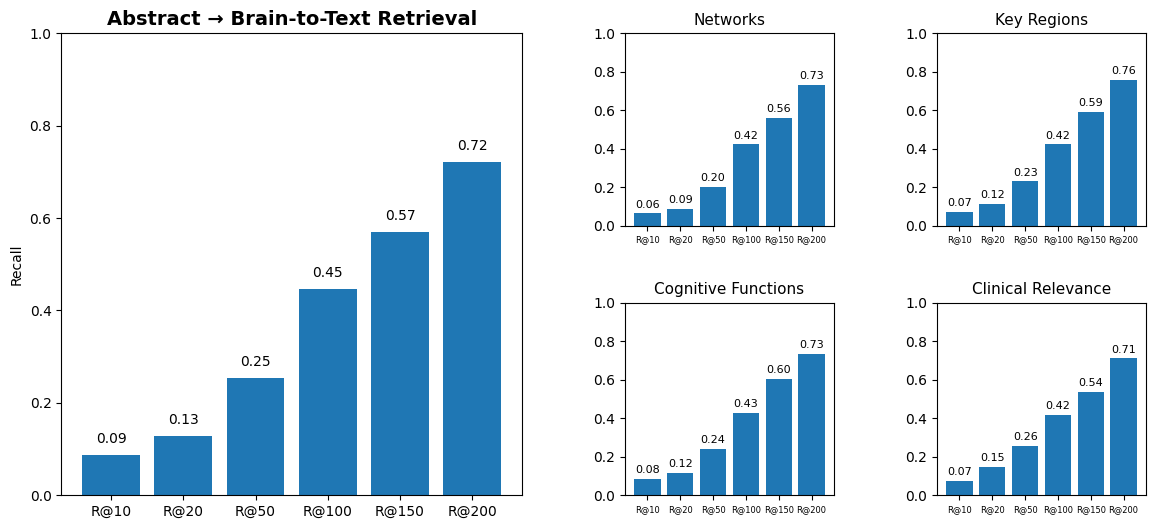

In [ ]:
# --- data ---
recalls = {
    "Abstract → Brain-to-Text": recall_abstract_btt,
    "Networks": recall_networks,
    "Key Regions": recall_key_regions,
    "Cognitive Functions": recall_cog_funcs,
    "Clinical Relevance": recall_clinical_relevance,
}

ks = sorted(recall_abstract_btt.keys())
x = np.arange(len(ks))

# --- figure layout ---
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 3, width_ratios=[2.2, 1, 1], wspace=0.35, hspace=0.4)

# --- left: main plot ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.bar(x, [recalls["Abstract → Brain-to-Text"][k] for k in ks])
ax_main.set_xticks(x)
ax_main.set_xticklabels([f"R@{k}" for k in ks])
ax_main.set_ylim(0, 1.0)
ax_main.set_ylabel("Recall")
ax_main.set_title("Abstract → Brain-to-Text Retrieval", fontsize=14, weight="bold")

# annotate values
for i, k in enumerate(ks):
    v = recalls["Abstract → Brain-to-Text"][k]
    ax_main.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=10)

# --- right: 4 smaller plots ---
titles = [
    "Networks",
    "Key Regions",
    "Cognitive Functions",
    "Clinical Relevance",
]

axes = [
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[1, 2]),
]

for ax, title in zip(axes, titles):
    vals = [recalls[title][k] for k in ks]
    ax.bar(x, vals)
    ax.set_xticks(x)
    ax.set_xticklabels([f"R@{k}" for k in ks], fontsize=6)
    ax.set_ylim(0, 1.0)
    ax.set_title(title, fontsize=11)

    for i, v in enumerate(vals):
        ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

# --- overall title ---
# fig.suptitle("Cross-Modal Retrieval Recall@K", fontsize=16, y=1.02)

plt.show()
